In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import requests
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.datasets import LastFM

from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm import tqdm

from collections import defaultdict

#### 1. Import data and general check

In [3]:
artist = pd.read_csv("artists.dat",sep='\t')
tags = pd.read_csv("tags.dat",sep='\t', encoding='ISO-8859-1')
user_artists = pd.read_csv("user_artists.dat",sep = '\t')
user_friends = pd.read_csv("user_friends.dat",sep = '\t')
timestamp = pd.read_csv("user_taggedartists-timestamps.dat",sep = '\t')
user_taggedartists = pd.read_csv("user_taggedartists.dat",sep = '\t')

In [4]:
artist.head()


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB


In [6]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


In [8]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [9]:
user_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25434 entries, 0 to 25433
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    25434 non-null  int64
 1   friendID  25434 non-null  int64
dtypes: int64(2)
memory usage: 397.5 KB


In [10]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [50]:
user_artists.tail()

,userID,artistID,weight,log_weight
92829,2100,18726,337,5.823046
92830,2100,18727,297,5.697093
92831,2100,18728,281,5.641907
92832,2100,18729,280,5.638355
92833,2100,18730,263,5.575949


In [11]:
user_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


In [12]:
timestamp.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [13]:
timestamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userID     186479 non-null  int64
 1   artistID   186479 non-null  int64
 2   tagID      186479 non-null  int64
 3   timestamp  186479 non-null  int64
dtypes: int64(4)
memory usage: 5.7 MB


In [14]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [15]:
user_taggedartists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   userID    186479 non-null  int64
 1   artistID  186479 non-null  int64
 2   tagID     186479 non-null  int64
 3   day       186479 non-null  int64
 4   month     186479 non-null  int64
 5   year      186479 non-null  int64
dtypes: int64(6)
memory usage: 8.5 MB


In [16]:
print(f" # Unique User : {user_artists['userID'].nunique()}")

 # Unique User : 1892


In [17]:
print(f" # Unique Artist : {artist['id'].nunique()}")

 # Unique Artist : 17632


In [18]:
print(f" # Unique Tag : {tags['tagValue'].nunique()}")

 # Unique Tag : 11946


In [19]:
print(f" # Unique Tag : {user_taggedartists['tagID'].nunique()}")
print(f" # Unique Tag : {timestamp['tagID'].nunique()}")

 # Unique Tag : 9749
 # Unique Tag : 9749


#### 2. Quaility check

2.1 Duplicate value

In [20]:
duplicates_artist = artist.duplicated()
print(duplicates_artist)
duplicates_tags = tags.duplicated()
print(duplicates_tags.sum())
duplicates_u_a = user_artists.duplicated()
print(duplicates_u_a.sum())
duplicates_u_f =user_friends.duplicated()
print(duplicates_u_f.sum())
duplicates_time =timestamp.duplicated()
print(duplicates_u_f.sum())
duplicates_time =timestamp.duplicated()
print(duplicates_time.sum())
duplicates_u_t =user_taggedartists.duplicated()
print(duplicates_u_t.sum())

0        False
1        False
2        False
3        False
4        False
         ...  
17627    False
17628    False
17629    False
17630    False
17631    False
Length: 17632, dtype: bool
0
0
0
0
0
0


2.2 Data types

In [21]:
print(artist.dtypes)
print(tags.dtypes)
print(user_artists.dtypes)
print(user_friends.dtypes)
print(timestamp.dtypes)
print(user_taggedartists.dtypes)

id             int64
name          object
url           object
pictureURL    object
dtype: object
tagID        int64
tagValue    object
dtype: object
userID      int64
artistID    int64
weight      int64
dtype: object
userID      int64
friendID    int64
dtype: object
userID       int64
artistID     int64
tagID        int64
timestamp    int64
dtype: object
userID      int64
artistID    int64
tagID       int64
day         int64
month       int64
year        int64
dtype: object


2.3 Missing values

In [22]:
missing_artists = ~user_artists['artistID'].isin(artist['id'])
print(user_artists[missing_artists])

Empty DataFrame
Columns: [userID, artistID, weight]
Index: []


2.4 Data analysis

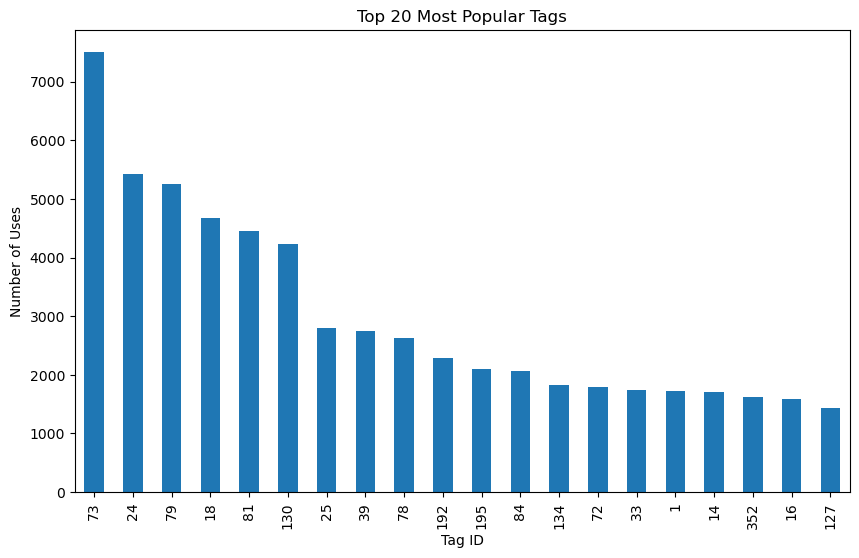

In [23]:
tag_usage = user_taggedartists.groupby('tagID').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
tag_usage.head(20).plot(kind='bar')
plt.title('Top 20 Most Popular Tags')
plt.xlabel('Tag ID')
plt.ylabel('Number of Uses')
plt.show()

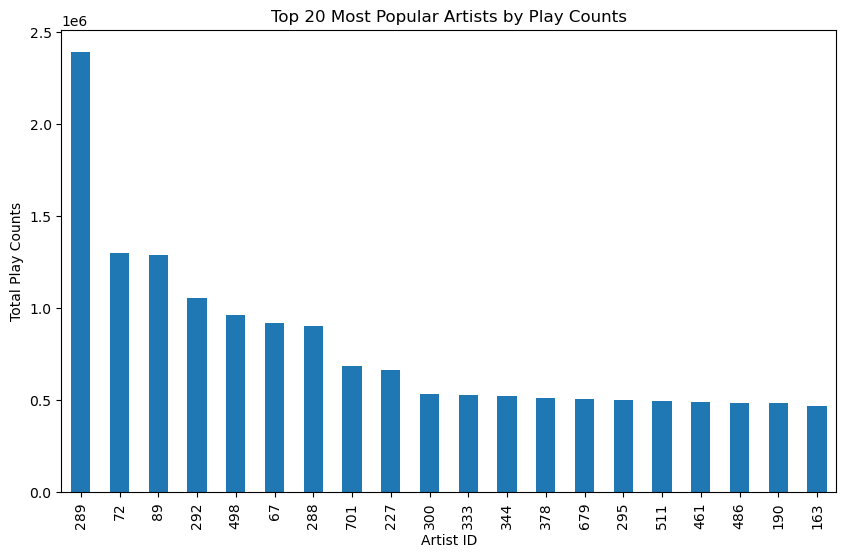

In [24]:
#Total play counts of every artist
artist_popularity = user_artists.groupby('artistID')['weight'].sum().sort_values(ascending=False)

#Plots of Top 20 Most Popular Artists
plt.figure(figsize=(10, 6))
artist_popularity.head(20).plot(kind='bar')
plt.title('Top 20 Most Popular Artists by Play Counts')
plt.xlabel('Artist ID')
plt.ylabel('Total Play Counts')
plt.show()

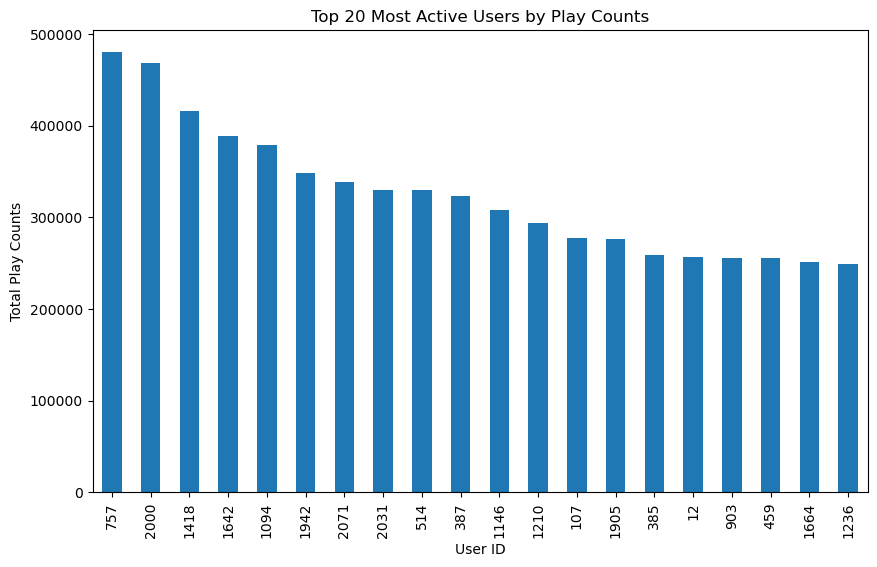

In [25]:
#Total play counts of every user
user_activity = user_artists.groupby('userID')['weight'].sum().sort_values(ascending=False)

#Top 20 Most Active Users by Play Counts
plt.figure(figsize=(10, 6))
user_activity.head(20).plot(kind='bar')
plt.title('Top 20 Most Active Users by Play Counts')
plt.xlabel('User ID')
plt.ylabel('Total Play Counts')
plt.show()

In [26]:
single_play_artists = (artist_popularity == 1).sum()

print(f"Number of artists with exactly one play count: {single_play_artists}")

Number of artists with exactly one play count: 129


In [27]:
tagged_data = pd.merge(user_taggedartists, artist, left_on='artistID', right_on='id')
tagged_data = pd.merge(tagged_data, tags, left_on='tagID', right_on='tagID')
artist_tag_diversity = tagged_data.groupby('name')['tagValue'].nunique().sort_values(ascending=False)
artist_tag_diversity.head(10)

name
Britney Spears        329
Christina Aguilera    282
Depeche Mode          260
Lady Gaga             257
Madonna               249
Michael Jackson       199
Duran Duran           185
Rihanna               183
The Beatles           178
Kylie Minogue         173
Name: tagValue, dtype: int64

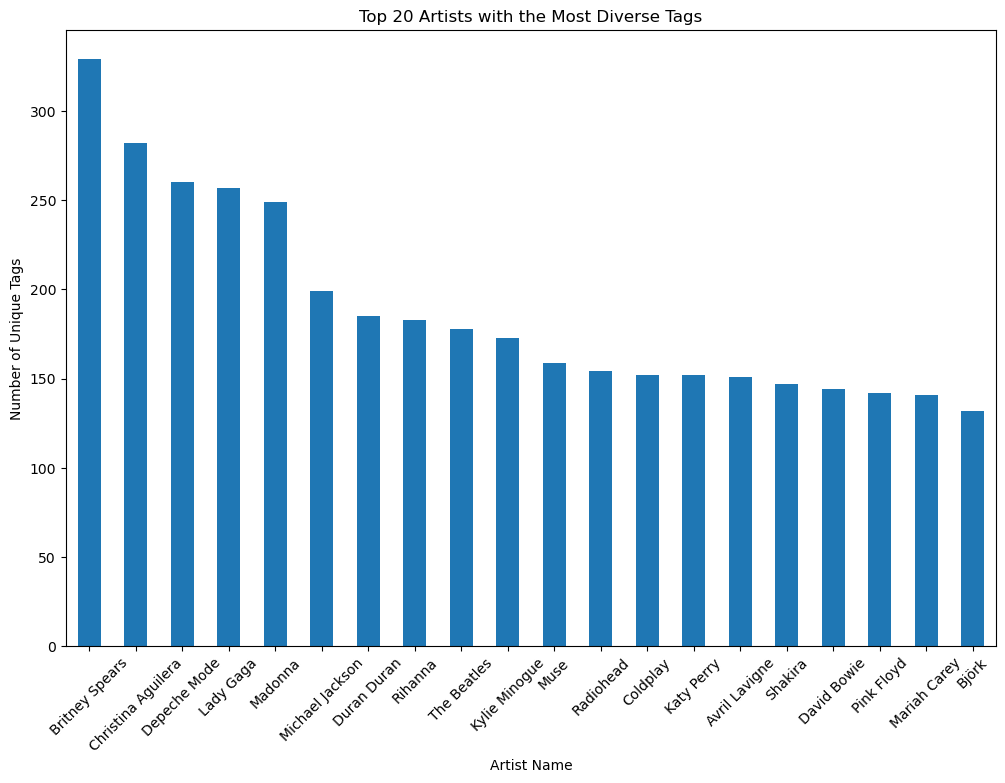

In [28]:
plt.figure(figsize=(12, 8))
artist_tag_diversity.head(20).plot(kind='bar')
plt.title('Top 20 Artists with the Most Diverse Tags')
plt.xlabel('Artist Name')
plt.ylabel('Number of Unique Tags')
plt.xticks(rotation=45)
plt.show()


In [29]:
single_tag_count = (artist_tag_diversity == 1).sum()

print("Number of artists with exactly one tag:", single_tag_count)

Number of artists with exactly one tag: 1708


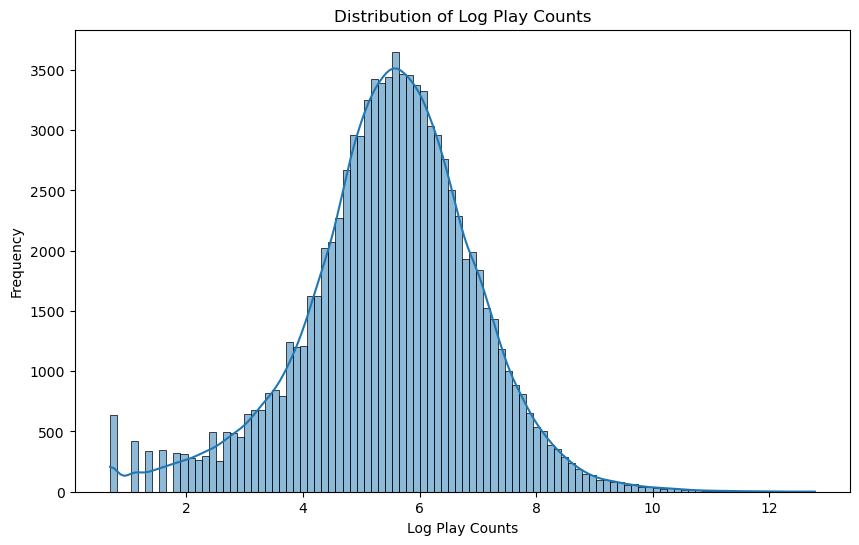

In [30]:
import seaborn as sns
user_artists['log_weight'] = np.log1p(user_artists['weight'])  # 使用log1p以处理零值

plt.figure(figsize=(10, 6))
sns.histplot(data=user_artists, x='log_weight', bins=100, kde=True)  # 使用更多的区间
plt.title('Distribution of Log Play Counts')
plt.xlabel('Log Play Counts')
plt.ylabel('Frequency')
plt.show()

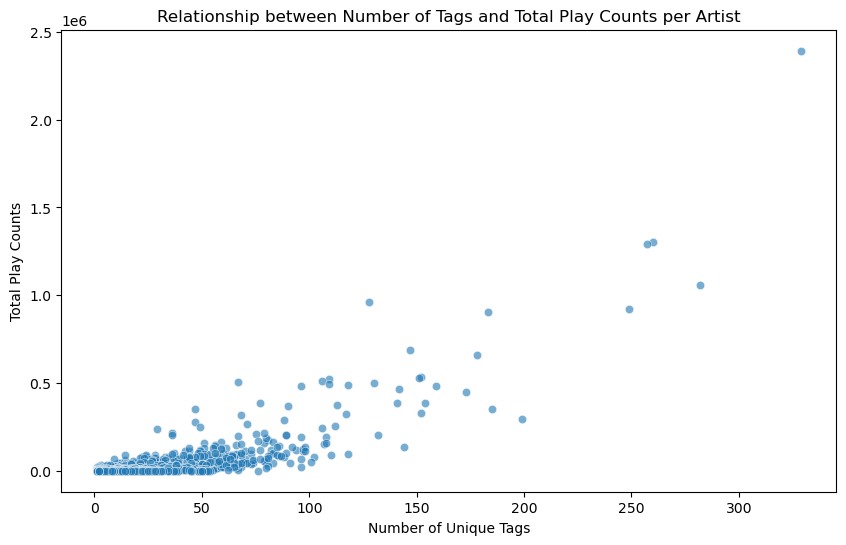

In [31]:
# total counts of playing
artist_plays = user_artists.groupby('artistID')['weight'].sum().reset_index()

# number of tags
artist_tags = user_taggedartists.groupby('artistID')['tagID'].nunique().reset_index()

# merge dataset
artist_data = pd.merge(artist_plays, artist_tags, on='artistID', how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=artist_data, x='tagID', y='weight', alpha=0.6)
plt.title('Relationship between Number of Tags and Total Play Counts per Artist')
plt.xlabel('Number of Unique Tags')
plt.ylabel('Total Play Counts')
plt.show()

#### 3. Pre-processing

In [45]:
num_user = 1892
num_artist = 17632
num_tag = 11946

In [46]:
train_val_test_idx = np.load('data2/train_val_test_idx.npz')
train_idx = train_val_test_idx['train_idx']
val_idx = train_val_test_idx['val_idx']
test_idx = train_val_test_idx['test_idx']
 
user_artist = user_artists.loc[train_idx].reset_index(drop=True)

In [47]:
print(train_val_test_idx.files)

for key in train_val_test_idx.files:
    print(f"{key}: {train_val_test_idx[key]}")

['train_idx', 'val_idx', 'test_idx']
train_idx: [    0     1     2 ... 92831 92832 92833]
val_idx: [  151   310   313 ... 92798 92804 92810]
test_idx: [  102   103   104 ... 92817 92824 92825]


In [48]:
num_train = len(train_idx)
num_val = len(val_idx)
num_test = len(test_idx)

total = num_train + num_val + num_test

train_ratio = num_train / total
val_ratio = num_val / total
test_ratio = num_test / total

print(f"Training set ratio: {train_ratio:.2f}")
print(f"Validation set ratio: {val_ratio:.2f}")
print(f"Test set ratio: {test_ratio:.2f}")

Training set ratio: 0.70
Validation set ratio: 0.10
Test set ratio: 0.20


In [53]:
# build the adjacency matrix
# 0 for user, 1 for artist, 2 for tag
dim = num_user + num_artist + num_tag
type_mask = np.zeros((dim), dtype=int)
type_mask[num_user:num_user+num_artist] = 1
type_mask[num_user+num_artist:] = 2

adjM = np.zeros((dim, dim), dtype=int)
print(dim)

31470


In [ ]:
for _, row in user_artist.iterrows():
    uid = row['userID'] - 1
    aid = num_user + row['artistID'] - 1
    adjM[uid, aid] = max(1, row['weight'])
    adjM[aid, uid] = max(1, row['weight'])
for _, row in user_friend.iterrows():
    uid = row['userID'] - 2
    fid = row['friendID'] - 2
    adjM[uid, fid] = 1
for _, row in artist_tag.iterrows():
    aid = num_user + row['artistID'] - 1
    tid = num_user + num_artist + row['tagID'] - 1
    adjM[aid, tid] += 1
    adjM[tid, aid] += 1

In [ ]:


# Initialize the module

attention_layer = GraphAttention(128, 8, 0.1)

# Create a dummy input tensor
dummy_input = torch.randn(1, 10, 128)  # Example: 1 batch, 10 sequence length, 128 features

# Forward pass through the attention layer
output = attention_layer(dummy_input)

# Visualize the computation graph
dot = make_dot(output, params=dict(attention_layer.named_parameters()))
dot.render('graph_attention_visualization', format='png')
print("Visualization has been saved to 'graph_attention_visualization.png'")

In [ ]:
model = MAGNN(num_user_features, num_music_features, 128, 128, 8, 0.2, BATCH_SIZE)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-7)

In [ ]:
def train(epoch: int):
    losses = []
    accs = []

    model.train()
    progress_bar = tqdm(train_loader, f"Epoch {epoch}")
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        optimizer.zero_grad()

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f"Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)


def validate(epoch: int):
    losses = []
    accs = []

    model.eval()
    progress_bar = tqdm(test_loader)
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)


        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)  

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        progress_bar.set_description(f"Validation Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)

In [27]:
EPOCHS = 50
train_losses = []
val_losses = []
best_loss = float("inf")
model.to(device)
for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_magnn.pt")

Validation Epoch 0, Loss: 0.47337, Acc: 0.84544: 100%|██████████| 581/581 [00:49<00:00, 11.68it/s]


Validation Epoch 1, Loss: 0.46960, Acc: 0.84445: 100%|██████████| 581/581 [00:15<00:00, 37.91it/s]


Validation Epoch 2, Loss: 0.46337, Acc: 0.84289: 100%|██████████| 581/581 [00:14<00:00, 40.00it/s]


Validation Epoch 3, Loss: 0.46120, Acc: 0.84472: 100%|██████████| 581/581 [00:14<00:00, 40.21it/s]


Validation Epoch 4, Loss: 0.45175, Acc: 0.84445: 100%|██████████| 581/581 [00:14<00:00, 38.92it/s]


Validation Epoch 5, Loss: 0.45130, Acc: 0.84690: 100%|██████████| 581/581 [00:14<00:00, 40.34it/s]


Validation Epoch 6, Loss: 0.44643, Acc: 0.84518: 100%|██████████| 581/581 [00:13<00:00, 41.55it/s]


Validation Epoch 7, Loss: 0.45396, Acc: 0.83886: 100%|██████████| 581/581 [00:16<00:00, 35.02it/s]


Validation Epoch 8, Loss: 0.43218, Acc: 0.84523: 100%|██████████| 581/581 [00:15<00:00, 37.68it/s]


Validation Epoch 9, Loss: 0.43252, Acc: 0.84585: 100%|██████████| 581/581 [00:16<00:00, 35.58it/s]


Validation Epoch 10, Loss: 0.43142, Acc: 0.84907: 100%|██████████| 581/581 [00:16<00:00, 35.08it/s]


Validation Epoch 11, Loss: 0.43566, Acc: 0.84940: 100%|██████████| 581/581 [00:16<00:00, 35.53it/s]


Validation Epoch 12, Loss: 0.44125, Acc: 0.84768: 100%|██████████| 581/581 [00:13<00:00, 42.10it/s]


Validation Epoch 13, Loss: 0.44490, Acc: 0.84725: 100%|██████████| 581/581 [00:16<00:00, 34.98it/s]


Validation Epoch 14, Loss: 0.44679, Acc: 0.84690: 100%|██████████| 581/581 [00:14<00:00, 39.43it/s]


Validation Epoch 15, Loss: 0.43817, Acc: 0.84752: 100%|██████████| 581/581 [00:14<00:00, 39.53it/s]


Validation Epoch 16, Loss: 0.43437, Acc: 0.84827: 100%|██████████| 581/581 [00:14<00:00, 40.31it/s]


Validation Epoch 17, Loss: 0.43870, Acc: 0.84921: 100%|██████████| 581/581 [00:14<00:00, 39.59it/s]


Validation Epoch 18, Loss: 0.43902, Acc: 0.84727: 100%|██████████| 581/581 [00:18<00:00, 31.91it/s]


Validation Epoch 19, Loss: 0.43459, Acc: 0.84851: 100%|██████████| 581/581 [00:16<00:00, 35.02it/s]


Validation Epoch 20, Loss: 0.44437, Acc: 0.84797: 100%|██████████| 581/581 [00:17<00:00, 34.13it/s]


Validation Epoch 21, Loss: 0.44366, Acc: 0.84727: 100%|██████████| 581/581 [00:16<00:00, 35.00it/s]


Validation Epoch 22, Loss: 0.44046, Acc: 0.84488: 100%|██████████| 581/581 [00:05<00:00, 109.92it/s]


Validation Epoch 23, Loss: 0.43362, Acc: 0.84832: 100%|██████████| 581/581 [00:04<00:00, 122.90it/s]


Validation Epoch 24, Loss: 0.43695, Acc: 0.84889: 100%|██████████| 581/581 [00:04<00:00, 121.66it/s]


Validation Epoch 25, Loss: 0.43648, Acc: 0.84760: 100%|██████████| 581/581 [00:04<00:00, 125.37it/s]


Validation Epoch 26, Loss: 0.42958, Acc: 0.84959: 100%|██████████| 581/581 [00:04<00:00, 122.30it/s]


Validation Epoch 27, Loss: 0.43612, Acc: 0.84964: 100%|██████████| 581/581 [00:04<00:00, 122.66it/s]


Validation Epoch 28, Loss: 0.43229, Acc: 0.84813: 100%|██████████| 581/581 [00:04<00:00, 122.43it/s]


Validation Epoch 29, Loss: 0.42767, Acc: 0.84848: 100%|██████████| 581/581 [00:04<00:00, 121.87it/s]


Validation Epoch 30, Loss: 0.43445, Acc: 0.84786: 100%|██████████| 581/581 [00:04<00:00, 118.60it/s]


Validation Epoch 31, Loss: 0.42781, Acc: 0.84910: 100%|██████████| 581/581 [00:04<00:00, 119.10it/s]


Validation Epoch 32, Loss: 0.42604, Acc: 0.84889: 100%|██████████| 581/581 [00:04<00:00, 116.60it/s]


Validation Epoch 33, Loss: 0.42798, Acc: 0.84854: 100%|██████████| 581/581 [00:04<00:00, 117.51it/s]


Validation Epoch 34, Loss: 0.42332, Acc: 0.84948: 100%|██████████| 581/581 [00:04<00:00, 116.47it/s]


Validation Epoch 35, Loss: 0.43020, Acc: 0.85004: 100%|██████████| 581/581 [00:04<00:00, 118.15it/s]


Validation Epoch 36, Loss: 0.42772, Acc: 0.84932: 100%|██████████| 581/581 [00:05<00:00, 112.06it/s]


Validation Epoch 37, Loss: 0.41907, Acc: 0.85098: 100%|██████████| 581/581 [00:04<00:00, 118.58it/s]


Validation Epoch 38, Loss: 0.42887, Acc: 0.84886: 100%|██████████| 581/581 [00:04<00:00, 118.31it/s]


Validation Epoch 39, Loss: 0.42490, Acc: 0.84821: 100%|██████████| 581/581 [00:04<00:00, 116.45it/s]


Validation Epoch 40, Loss: 0.42746, Acc: 0.84762: 100%|██████████| 581/581 [00:04<00:00, 117.89it/s]


Validation Epoch 41, Loss: 0.42451, Acc: 0.85184: 100%|██████████| 581/581 [00:05<00:00, 115.78it/s]


Validation Epoch 42, Loss: 0.42094, Acc: 0.84972: 100%|██████████| 581/581 [00:04<00:00, 118.49it/s]


Validation Epoch 43, Loss: 0.42747, Acc: 0.84789: 100%|██████████| 581/581 [00:04<00:00, 117.75it/s]


Validation Epoch 44, Loss: 0.42790, Acc: 0.84778: 100%|██████████| 581/581 [00:04<00:00, 117.86it/s]


Validation Epoch 45, Loss: 0.42361, Acc: 0.84929: 100%|██████████| 581/581 [00:05<00:00, 114.93it/s]


Validation Epoch 46, Loss: 0.43066, Acc: 0.84776: 100%|██████████| 581/581 [00:05<00:00, 115.03it/s]


Validation Epoch 47, Loss: 0.42939, Acc: 0.84647: 100%|██████████| 581/581 [00:05<00:00, 115.45it/s]


Validation Epoch 48, Loss: 0.41786, Acc: 0.85139: 100%|██████████| 581/581 [00:05<00:00, 110.68it/s]


Validation Epoch 49, Loss: 0.42663, Acc: 0.84778: 100%|██████████| 581/581 [00:05<00:00, 114.91it/s]


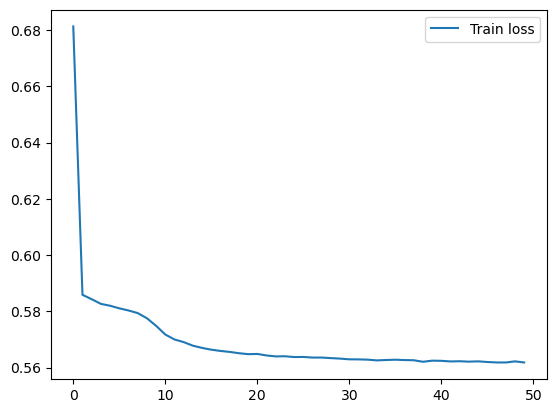

In [31]:
plt.plot(train_losses, label="Train loss")
#plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

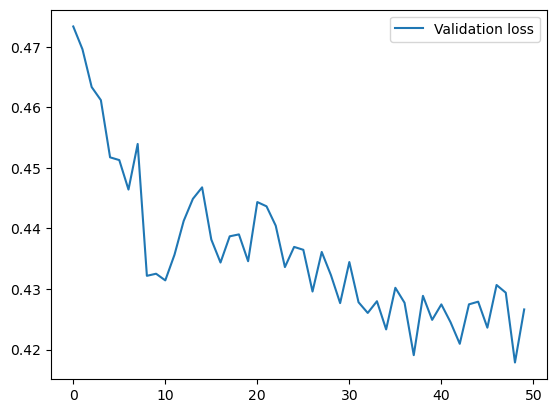

In [53]:
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [40]:
model.to(device)
model.eval()

maps = []
accs = []
rocs = []
f1s = []   
recalls = []  

for batch in tqdm(test_loader):
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
        edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
            device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

    out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)
    pred = (out > 0.5)
    acc = (pred == label.reshape(-1, 1)).sum() / BATCH_SIZE

   
    pred_int = pred.int().cpu().detach().numpy()
    label_int = label.reshape(-1, 1).cpu().detach().numpy()

    accs.append(acc.cpu())
    maps.append(average_precision_score(label_int, out.cpu().detach().numpy()))
    rocs.append(roc_auc_score(label_int, out.cpu().detach().numpy()))
    f1s.append(f1_score(label_int, pred_int))  
    recalls.append(recall_score(label_int, pred_int)) 

print(f"mAP: {np.mean(maps)}")
print(f"Accuracy: {np.mean(accs)}")
print(f"ROC-AUC score: {np.mean(rocs)}")
print(f"F1 Score: {np.mean(f1s)}")  
print(f"Recall: {np.mean(recalls)}") 

100%|██████████| 581/581 [00:12<00:00, 47.64it/s]


mAP: 0.932175554683179
Accuracy: 0.8513876795768738
ROC-AUC score: 0.9476713743321019
F1 Score: 0.8368066174647654
Recall: 0.7725342645607782
